In [2]:
# Load Pre-trained Model
# Example: Loading a PyTorch model
import torch
import os
import sys
import numpy as np
import pywt

os.chdir("/Users/kaspervanderhorst/Desktop/thesis")
# Correctly resolve the src directory at the root of the project
src_path = os.path.abspath(os.path.join(os.getcwd(), "..", "src"))
if src_path not in sys.path:
    sys.path.append(src_path)

# Verify that src is in the Python path
print(f"Added {src_path} to Python path.")

# Import the model
from src.models.base_model import RRCNNDecomposer

# Specify the path to the saved model checkpoint
model_path = "/Users/kaspervanderhorst/Desktop/thesis/models/band_overlap.pth"
# Load the model
model = RRCNNDecomposer()  # Adjust parameters as per your model
model.load_state_dict(torch.load(model_path))
model.eval()  # Set the model to evaluation mode

Added /Users/kaspervanderhorst/Desktop/src to Python path.


RRCNNDecomposer(
  (imf_extractors): ModuleList(
    (0-1): 2 x RRCNNLayer(
      (conv): Conv1d(1, 16, kernel_size=(5,), stride=(1,), padding=(2,))
      (relu): ReLU()
      (out_conv): Conv1d(16, 1, kernel_size=(5,), stride=(1,), padding=(2,))
    )
  )
)

In [3]:
# Resolve the dataset path
dataset_path = "/Users/kaspervanderhorst/Desktop/thesis/src/data/data_storage/composite_signals_20250501T130125.npz"

# Load the dataset
data = np.load(dataset_path)
X = data['composite_signals']
y = data['components']  # Ground truth components

print(f"Loaded dataset with {X.shape[0]} samples.")

Loaded dataset with 100 samples.


In [4]:
# Train-Test Split
from sklearn.model_selection import train_test_split

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

Training set size: 90
Testing set size: 10


In [5]:
# Make Predictions
# Convert test data to PyTorch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
print(f"Shape of X_test_tensor: {X_test_tensor.shape}")
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
print(f"Shape of X_test_tensor: {X_test_tensor.shape}")

# Make predictions
with torch.no_grad():
    predictions = model(X_test_tensor)

print("Predictions shape:", predictions.shape)

Shape of X_test_tensor: torch.Size([10, 1000])
Shape of X_test_tensor: torch.Size([10, 1, 1000])
Predictions shape: torch.Size([10, 2, 1000])


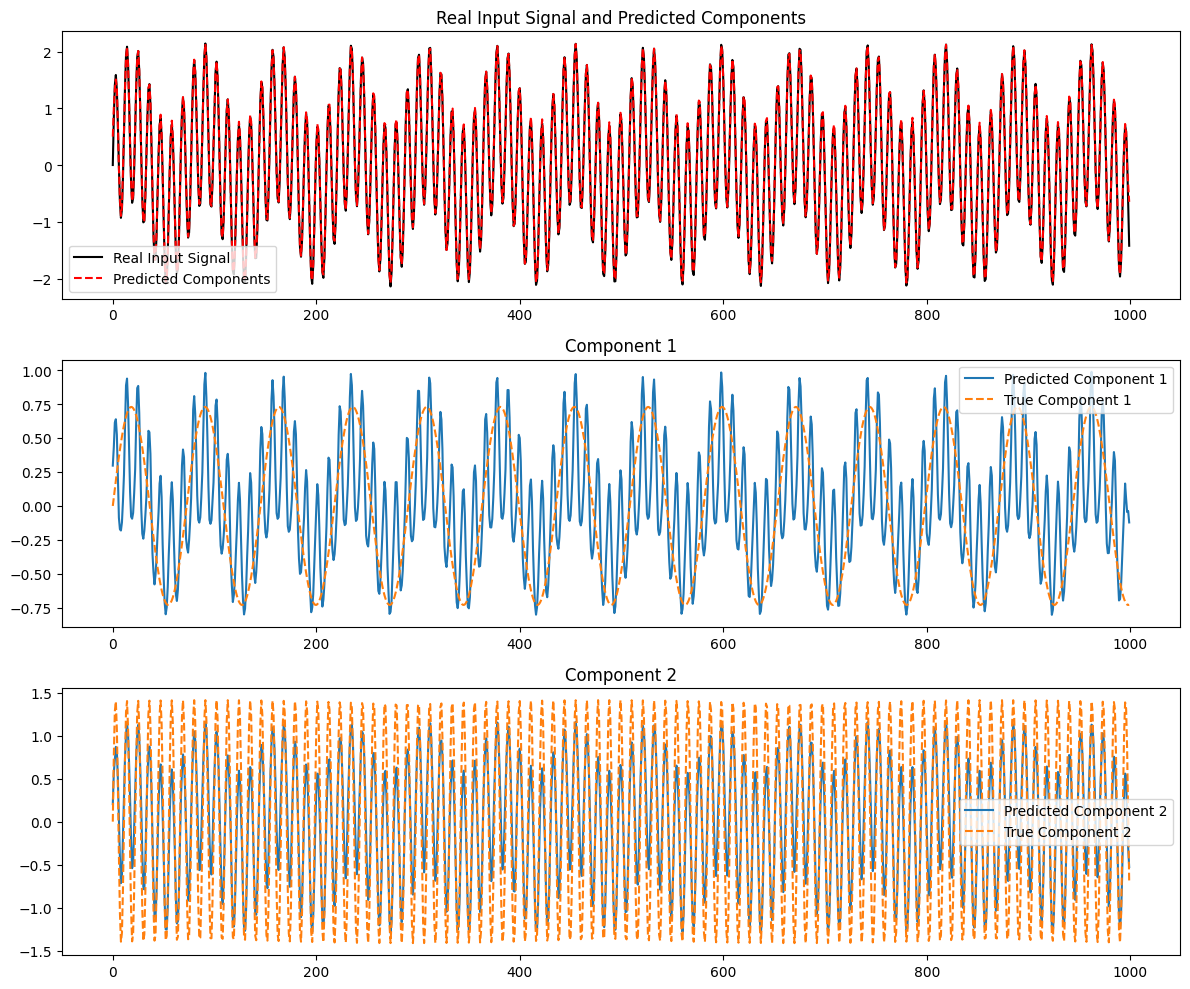

In [13]:
# Inspect Decompositions with Composite Signal
# Visualize the real input signal, predicted components, and true components
import matplotlib.pyplot as plt

# Select a sample to visualize
sample_idx = 6
composite_signal = X_test[sample_idx]
predicted_components = predictions[sample_idx].numpy()
true_components = y_test[sample_idx]

# Plot the real input signal and predicted components
plt.figure(figsize=(12, 10))

# Top plot: Real input signal and predicted components
plt.subplot(3, 1, 1)
plt.plot(composite_signal, label="Real Input Signal", color="black")
plt.plot(predicted_components.sum(axis=0), label="Predicted Components", color="red", linestyle="dashed")
plt.title("Real Input Signal and Predicted Components")
plt.legend()


# Middle plot: First predicted and true component
plt.subplot(3, 1, 2)
plt.plot(predicted_components[0], label="Predicted Component 1")
plt.plot(true_components[0], label="True Component 1", linestyle="dashed")
plt.title("Component 1")
plt.legend()

# Bottom plot: Second predicted and true component
plt.subplot(3, 1, 3)
plt.plot(predicted_components[1], label="Predicted Component 2")
plt.plot(true_components[1], label="True Component 2", linestyle="dashed")
plt.title("Component 2")
plt.legend()

plt.tight_layout()
plt.show()

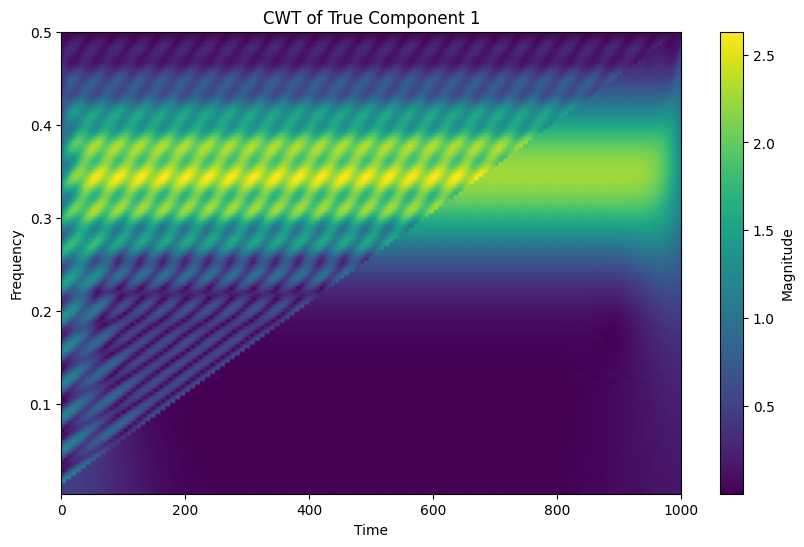

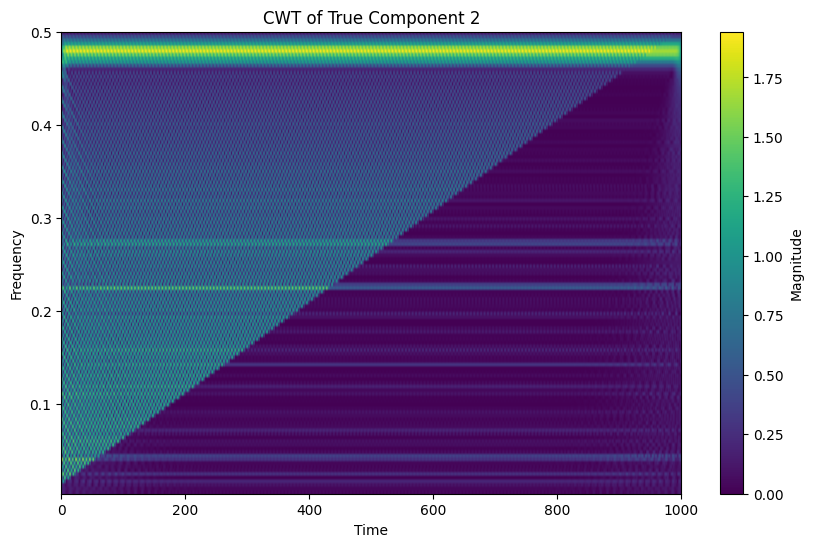

In [21]:

# Select a sample to analyze
sample_idx = 6
true_components = y_test[sample_idx]

# Define wavelet and scales
wavelet = 'cmor'  # Complex Morlet wavelet
scales = np.arange(1, 128)  # Adjust scales as needed

# Compute CWT for each component
for i, component in enumerate(true_components):
    coefficients, frequencies = pywt.cwt(component, scales, wavelet)
    
    # Plot the CWT
    plt.figure(figsize=(10, 6))
    plt.imshow(
        np.abs(coefficients), 
        extent=[0, len(component), frequencies[-1], frequencies[0]], 
        aspect='auto', 
        cmap='viridis'
    )
    plt.colorbar(label='Magnitude')
    plt.title(f'CWT of True Component {i + 1}')
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.show()

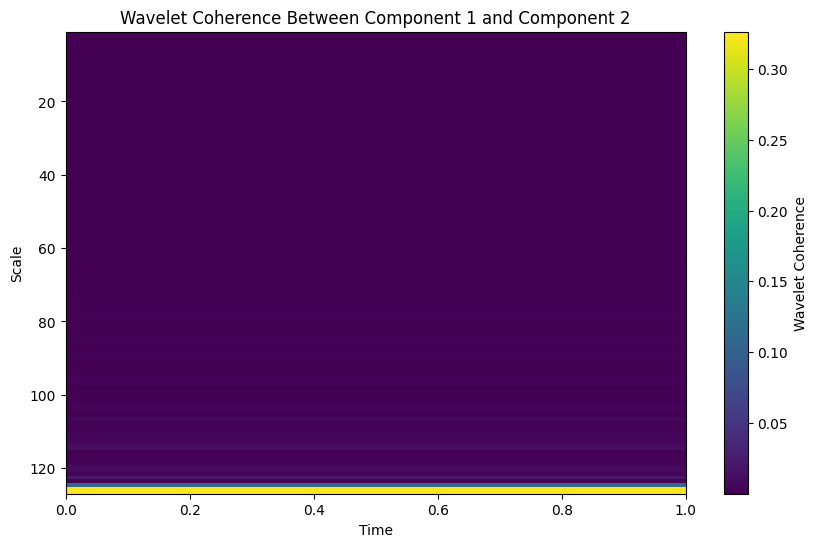

In [22]:
# Select a sample to analyze
sample_idx = 6
true_components = y_test[sample_idx]

# Define wavelet and scales
wavelet = 'cmor'  # Complex Morlet wavelet
scales = np.arange(1, 128)  # Adjust scales as needed

# Compute CWT for the first two components
coefficients_1, _ = pywt.cwt(true_components[0], scales, wavelet)
coefficients_2, _ = pywt.cwt(true_components[1], scales, wavelet)

# Compute wavelet coherence
numerator = np.abs(np.mean(coefficients_1 * np.conj(coefficients_2), axis=1)) ** 2
denominator = np.mean(np.abs(coefficients_1) ** 2, axis=1) * np.mean(np.abs(coefficients_2) ** 2, axis=1)
coherence = numerator / denominator

# Plot wavelet coherence
plt.figure(figsize=(10, 6))
plt.imshow(
    coherence.reshape(-1, 1),  # Reshape for visualization
    extent=[0, 1, scales[-1], scales[0]],  # Time axis is arbitrary here
    aspect='auto',
    cmap='viridis'
)
plt.colorbar(label='Wavelet Coherence')
plt.title('Wavelet Coherence Between Component 1 and Component 2')
plt.xlabel('Time')
plt.ylabel('Scale')
plt.show()